**Student**: Lucas Versini

In [1]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision.datasets import SVHN, MNIST, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

## UMAP
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  print("Using Google Colab")
  !pip install umap-learn
  from umap import UMAP
  !pip install adapt
else:
  from umap import UMAP  

# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1
CUDA device found.
Number of GPU cards:  1 
Which card GPU? NVIDIA RTX A5000
Total GPU memory 25.40 GB. Free GPU memory 25.06 GB


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [3]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

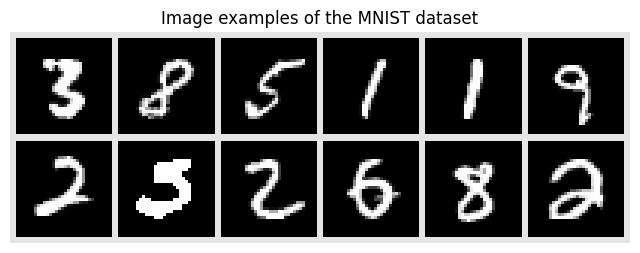

In [4]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating teh Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [5]:
#This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()

In [6]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255


Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [7]:
MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=len(MNIST_train_dataset))
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()


In [8]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()))

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


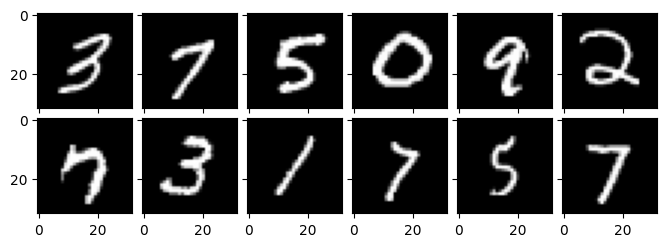

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES=12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0,len(MNIST_Xtrain_ima),12),:,:]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')

plt.show()

So we have 60k training images and 10K test images of size $[32 \times 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32x32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [10]:
SVHN_train_dataset = SVHN(root=DATASET_PATH, split='train', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


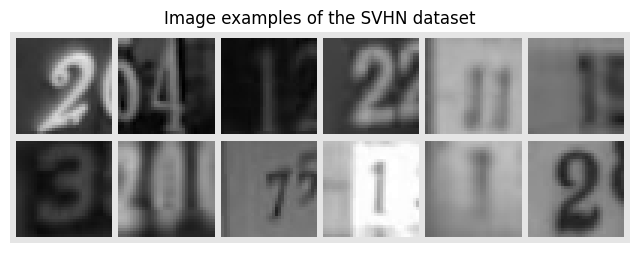

In [11]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [12]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()


In [13]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()))

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 \times 32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16x16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 x 32$ images.

In [14]:
USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))

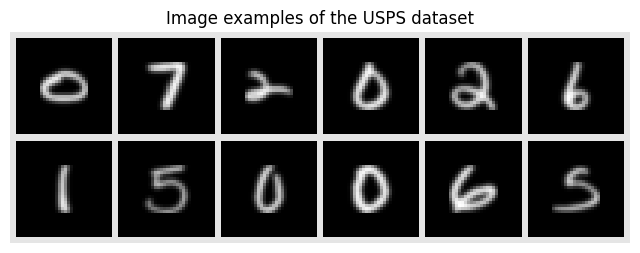

In [15]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack([USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(USPS_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [16]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [ ]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtest_ima.min(), USPS_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()))

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 x 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> 32 x 32 = 1024

In [18]:
# MNIST
MNIST_Xtrain = np.reshape(MNIST_Xtrain_ima, (MNIST_Xtrain_ima.shape[0], -1))
MNIST_Xtest = np.reshape(MNIST_Xtest_ima, (MNIST_Xtest_ima.shape[0], -1))

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)

# USPS
USPS_Xtrain = np.reshape(USPS_Xtrain_ima, (USPS_Xtrain_ima.shape[0], -1))
USPS_Xtest = np.reshape(USPS_Xtest_ima, (USPS_Xtest_ima.shape[0], -1))

print(USPS_Xtrain.shape, USPS_Xtest.shape)

# SVHN
SVHN_Xtrain = np.reshape(SVHN_Xtrain_ima, (SVHN_Xtrain_ima.shape[0], -1))
SVHN_Xtest = np.reshape(SVHN_Xtest_ima, (SVHN_Xtest_ima.shape[0], -1))

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [19]:
np.random.seed(0)
n_samples = 1000

# Reduced MNIST
idx = np.random.choice(MNIST_Xtrain.shape[0], n_samples, replace = False)
MNIST_Xtrain_res = MNIST_Xtrain[idx]
MNIST_ytrain_res = MNIST_ytrain[idx]

# Reduced USPS
idx = np.random.choice(USPS_Xtrain.shape[0], n_samples, replace = False)
USPS_Xtrain_res = USPS_Xtrain[idx]
USPS_ytrain_res = USPS_ytrain[idx]

# Reduced SVHN
idx = np.random.choice(SVHN_Xtrain.shape[0], n_samples, replace = False)
SVHN_Xtrain_res = SVHN_Xtrain[idx]
SVHN_ytrain_res = SVHN_ytrain[idx]


# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]

In [20]:
xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

(3000, 2)


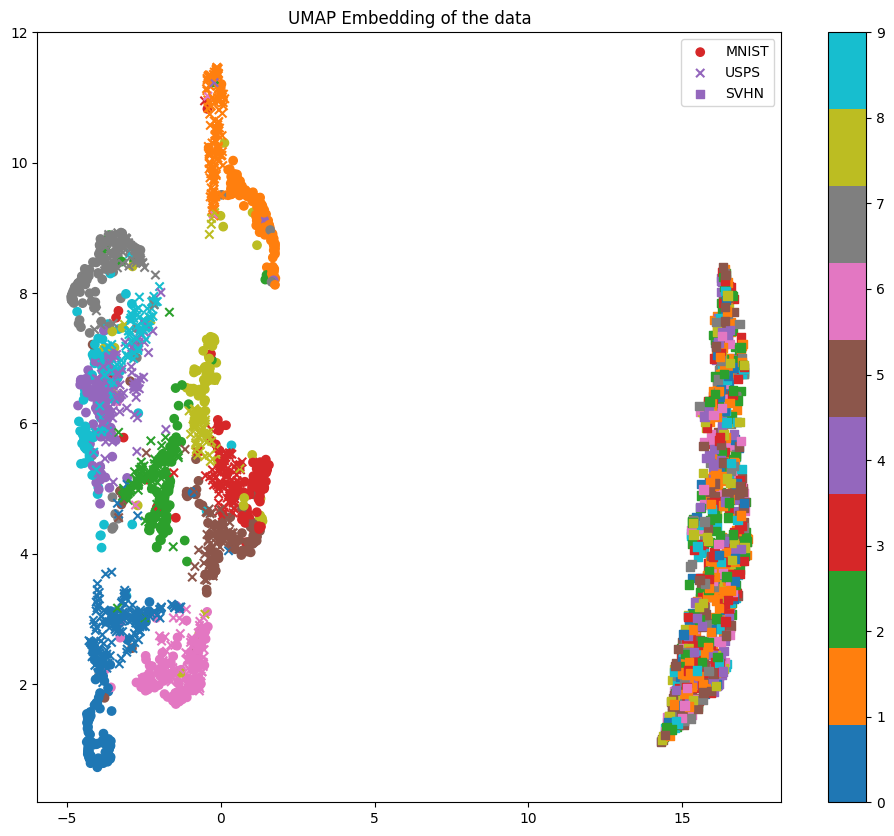

In [21]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

**Answer**: It seems indeed that SVHN is very different from MNIST and USPS.

However, MNIST and USPS seem quite close.

Moreover, for these two datasets, it seems that the classes are separated. Let us re-run UMAP only on these two datasets.

(2000, 2)


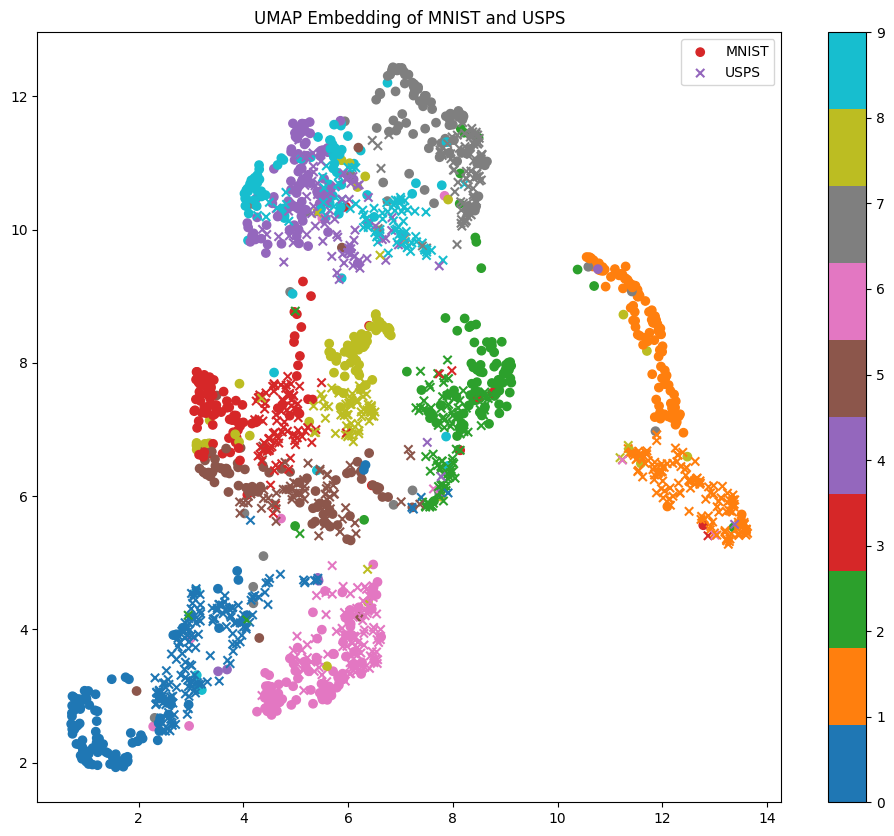

In [22]:
x_MNIST_USPS = np.concatenate((MNIST_Xtrain_res, USPS_Xtrain_res), axis = 0) # Only MNIST and USPS
nMNIST = MNIST_Xtrain_res.shape[0]
nUSPS = USPS_Xtrain_res.shape[0]

xp = UMAP().fit_transform(x_MNIST_USPS)
print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST, :]
xpUSPS=xp[nMNIST:nMNIST + nUSPS, :]

plt.figure(3, (12, 10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of MNIST and USPS')
plt.show()

**Question**: Can you see a domain shift between the datasets ?

**Answer**: As said previously, SVHN is very different from MNIST and USPS.

As for MNIST and USPS, they do not totally look alike. For instance, images of 6 are quite clustered in the above figures (no matter whether they come from MNIST or from USPS), whereas images of 1 are separated between the two datasets (though still rather close).

So there is a domain shift, but much smaller than between MNIST and SVHN or between USPS and SVHN.

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [23]:
# All three datasets

%time
xp=TSNE().fit_transform(xtot) # this should take around 50 sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]
print(xpMNIST.shape,xpUSPS.shape,xpSVHN.shape)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.01 μs


(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


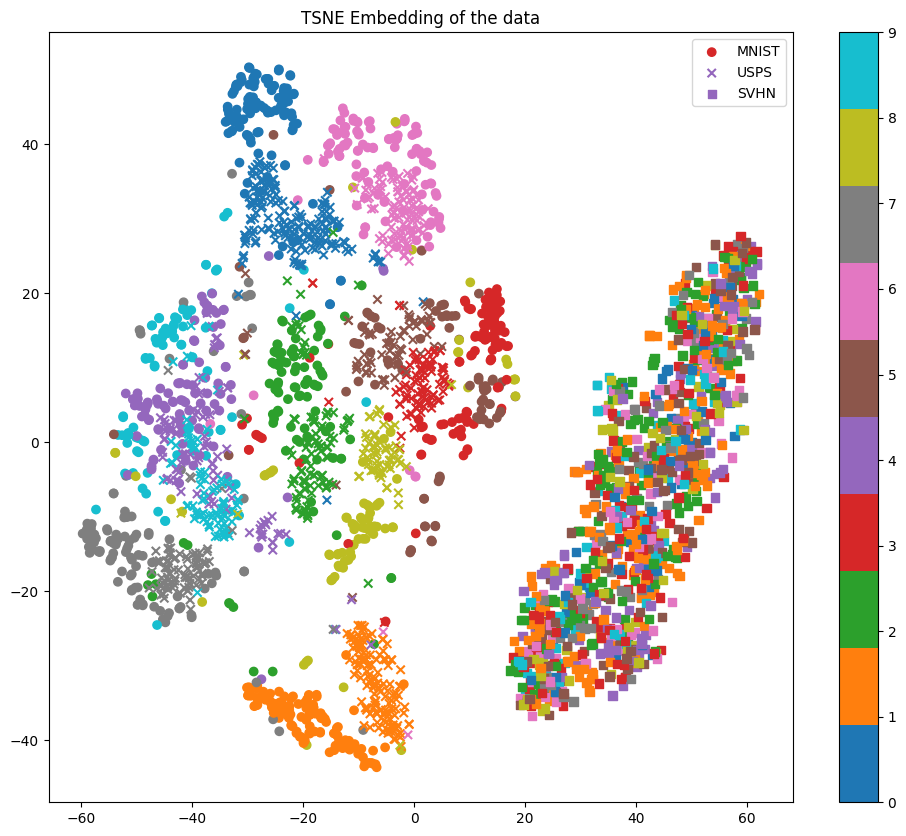

In [24]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')
plt.show()

In [25]:
# Only MNIST and USPS

%time
xp=TSNE().fit_transform(x_MNIST_USPS)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

CPU times: user 46 μs, sys: 1 μs, total: 47 μs
Wall time: 5.96 μs


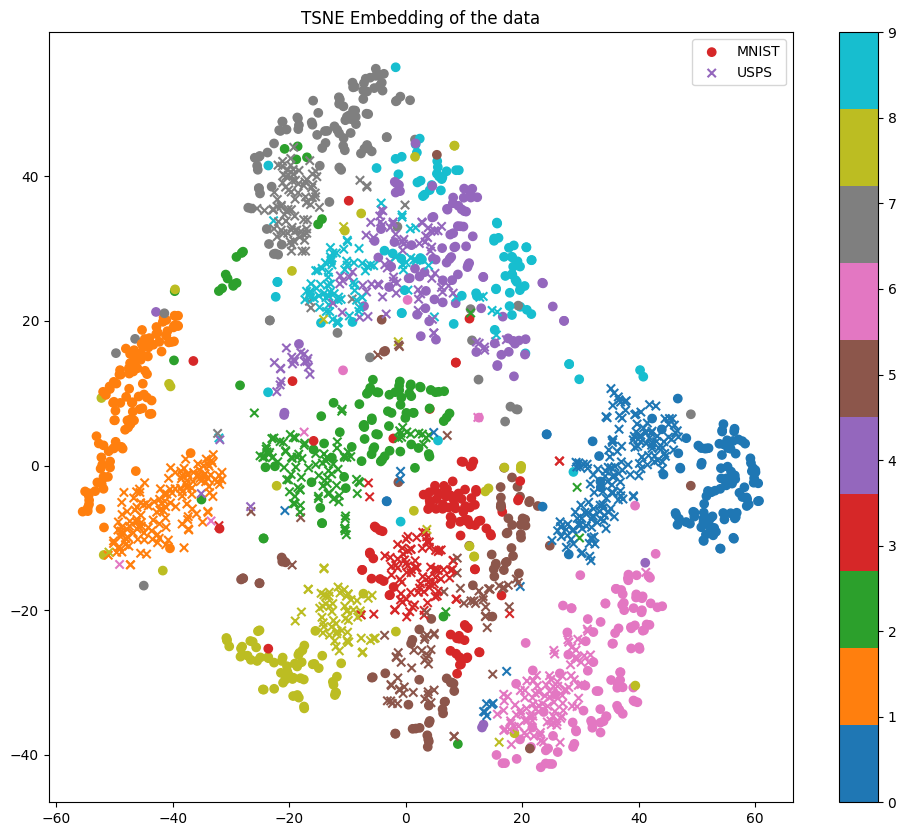

In [26]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')
plt.show()

**Question**: can you confirm your previous conclusions ?

**Answer**: The results with TSNE are the same as with UMAP: MNIST and USPS are rather close (though there is still a shift for some classes), and SVHN is very different from them.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

(1000, 2)


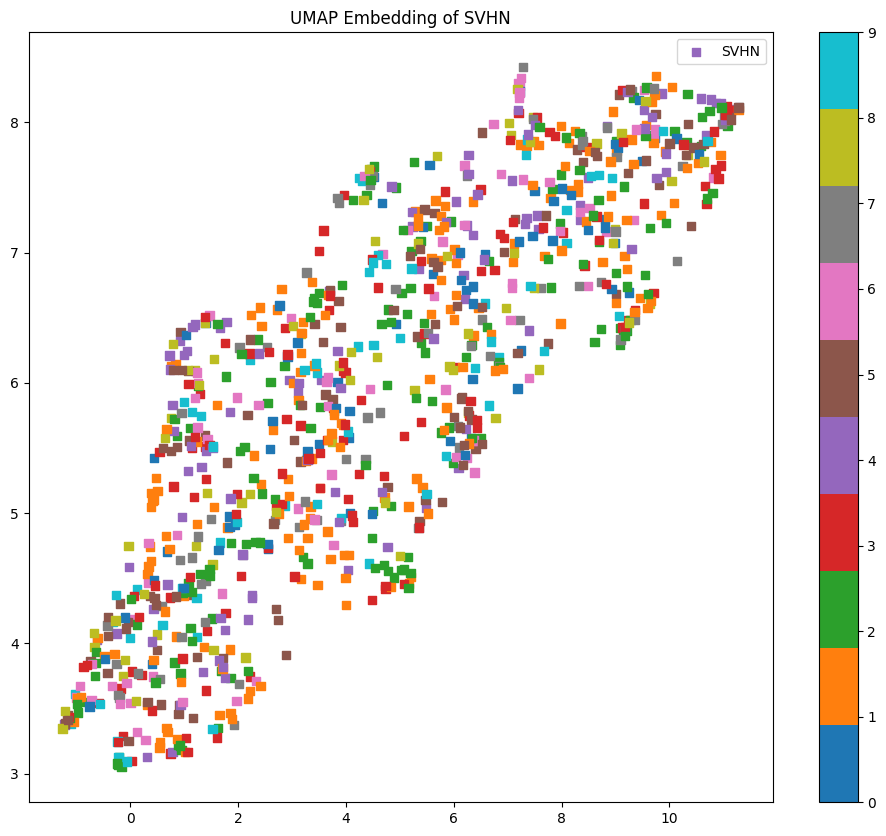

In [27]:
xp = UMAP().fit_transform(SVHN_Xtrain_res)
print(xp.shape)

plt.figure(3, (12, 10))
plt.scatter(xp[:,0],xp[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of SVHN')
plt.show()

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?

Hint: think about the input space of UMAP...

**Answer**: we see that the data is not clearly clustered at all: images which belong to the same class can be quite far away (in the 2D embedding), and images which belong to different classes can be quite close.

This can be explained by the large diversity of the images. Some of them are white digits on a black background, some of them are the opposite. The level of blur varies, the digits are not always at the center of the images.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 \times 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previousyly computed reduced datasets to speed up computations.

In [28]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [29]:
from sklearn.decomposition import PCA

def SA(XTrainS, XTestS, XTrainT, XTestT, d = 10):
  """
  Subspace Alignment (SA)

  Input
  XTrainS : Input training source data [NTrS,D]
  XTestS : Input test source data [NTeS,D]
  XTrainT : Input training target data [NTrT,D]
  XTestT : Input test target data [NTeT,D]
  d : number of PCA components

  Output
  XTrainSp : projected and transformed source training data [NTrS,d]
  XTestSp : projected and transformed source test data [NTeS,d]
  XTrainTp : projected training target data [NTrT,d]
  XTestTp : projected test target data [NTeT,d]
  """
  # # Center and scale the data
  # S_train_mean, S_train_std = XTrainS.mean(axis=0), XTrainS.std(axis=0)
  # S_train_std[S_train_std == 0] = 1
  # XTrainS = (XTrainS - S_train_mean) / S_train_std
  # XTestS = (XTestS - S_train_mean) / S_train_std

  # T_train_mean, T_train_std = XTrainT.mean(axis=0), XTrainT.std(axis=0)
  # T_train_std[T_train_std == 0] = 1
  # XTrainT = (XTrainT - T_train_mean) / T_train_std
  # XTestT = (XTestT - T_train_mean) / T_train_std

  # PCA for source domain and target domain
  US = PCA(n_components = d).fit(XTrainS).components_.T
  UT = PCA(n_components = d).fit(XTrainT).components_.T

  # Linear transformation
  M = US.T @ UT

  # Projection
  XTrainSp, XTestSp = XTrainS @ US @ M, XTestS @ US @ M
  XTrainTp, XTestTp = XTrainT @ UT, XTestT @ UT

  return XTrainSp, XTestSp, XTrainTp, XTestTp

We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

**Answer**: we use a Ridge Classifier (linear), a Random Forest (non-linear), and a basic MLP.

In [34]:
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

class MLP(torch.nn.Module):
  """ Basic Multi-layer Perceptron (MLP) """
  def __init__(self, input_dim = 32 * 32, hidden_dim = 128, output_dim = 10):
    super(MLP, self).__init__()
    self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def fit(self, X, y, epochs = 100, lr = 0.01):
    X = torch.tensor(X, dtype = torch.float32)
    y = torch.tensor(y, dtype = torch.long)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr = lr)
    for _ in range(epochs):
      optimizer.zero_grad()
      outputs = self(X)
      loss = criterion(outputs, y)
      loss.backward()
      optimizer.step()
    return self
    
  def score(self, X, y):
    X = torch.tensor(X, dtype = torch.float32)
    y = torch.tensor(y, dtype = torch.long)
    outputs = self(X)
    _, predicted = torch.max(outputs, 1)
    return (predicted == y).sum().item() / len(y)

def get_args(method, d):
  """ Get default arguments for different classifiers """
  if method == MLP:
    return {"input_dim": d}
  elif method == RidgeClassifier:
    return {}
  elif method == SVC:
    return {"kernel": "rbf", "C": 1, "gamma": "scale"}
  elif method == RandomForestClassifier:
    return {"n_estimators": 100}
  elif method == KNeighborsClassifier:
    return {"n_neighbors": 10}

def train_evaluate(method, name, XtrainS, ytrainS, XtestT, ytestT, verbose = True):
  """ Train and evaluate a classifier """
  t0 = time.time()

  args = get_args(method, XtrainS.shape[1])
  clf = method(**args).fit(XtrainS, ytrainS)
  score = clf.score(XtestT, ytestT)
  if verbose:
    print(f"Score without adaptation ({name}): {score:.3f}")
  return score, time.time() - t0

def plot_results(methods, results, results_basic, label_baseline = "", label_adapt = ""):
  """ Plot results (accuracy and time) for different methods """
  plt.figure(figsize = (12, 4 * len(methods)))
  for i, method in enumerate(methods):
    name = method[1]

    d = [r[0] for r in results[name]]
    acc = [r[1] for r in results[name]]
    t = [r[2] for r in results[name]]

    plt.subplot(len(methods), 2, 2 * i + 1)
    plt.plot(d, acc, label = label_adapt)
    plt.axhline(results_basic[name][0], color = "red", linestyle = "--", label = label_baseline)
    plt.xscale("log")
    plt.xlabel("Number of PCA components")
    plt.ylabel("Accuracy")
    if label_baseline != "" or label_adapt != "":
      plt.legend()
    plt.title(name + " (accuracy)")

    plt.subplot(len(methods), 2, 2 * i + 2)
    plt.plot(d, t, label = label_adapt)
    plt.axhline(results_basic[name][1], color = "red", linestyle = "--", label = label_baseline)
    plt.xscale("log")
    plt.xlabel("Number of PCA components")
    plt.ylabel("Time (s)")
    if label_baseline != "" or label_adapt != "":
      plt.legend()
    plt.title(name + " (time)")
  plt.tight_layout()
  plt.show()

# List of the classifiers to use
methods = [
          (RidgeClassifier, "Ridge Classifier"),
          (KNeighborsClassifier, "KNN"),
          (RandomForestClassifier, "Random Forest"),
          (SVC, "SVM"),
          (MLP, "MLP")
          ]

In [35]:
# Basic results (without adaptation) for each method
results_basic = {}

for method, name in methods:    
  score, t = train_evaluate(method, name, XtrainS, ytrainS, XtestT, ytestT)
  results_basic[name] = (score, t)

Score without adaptation (Ridge Classifier): 0.526
Score without adaptation (KNN): 0.386
Score without adaptation (Random Forest): 0.600
Score without adaptation (SVM): 0.527
Score without adaptation (MLP): 0.610


**Answer**: For the above classifiers, trained on MNIST and evaluated on USPS, the accuracy is (roughly) between 50 % and 60%.

To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?

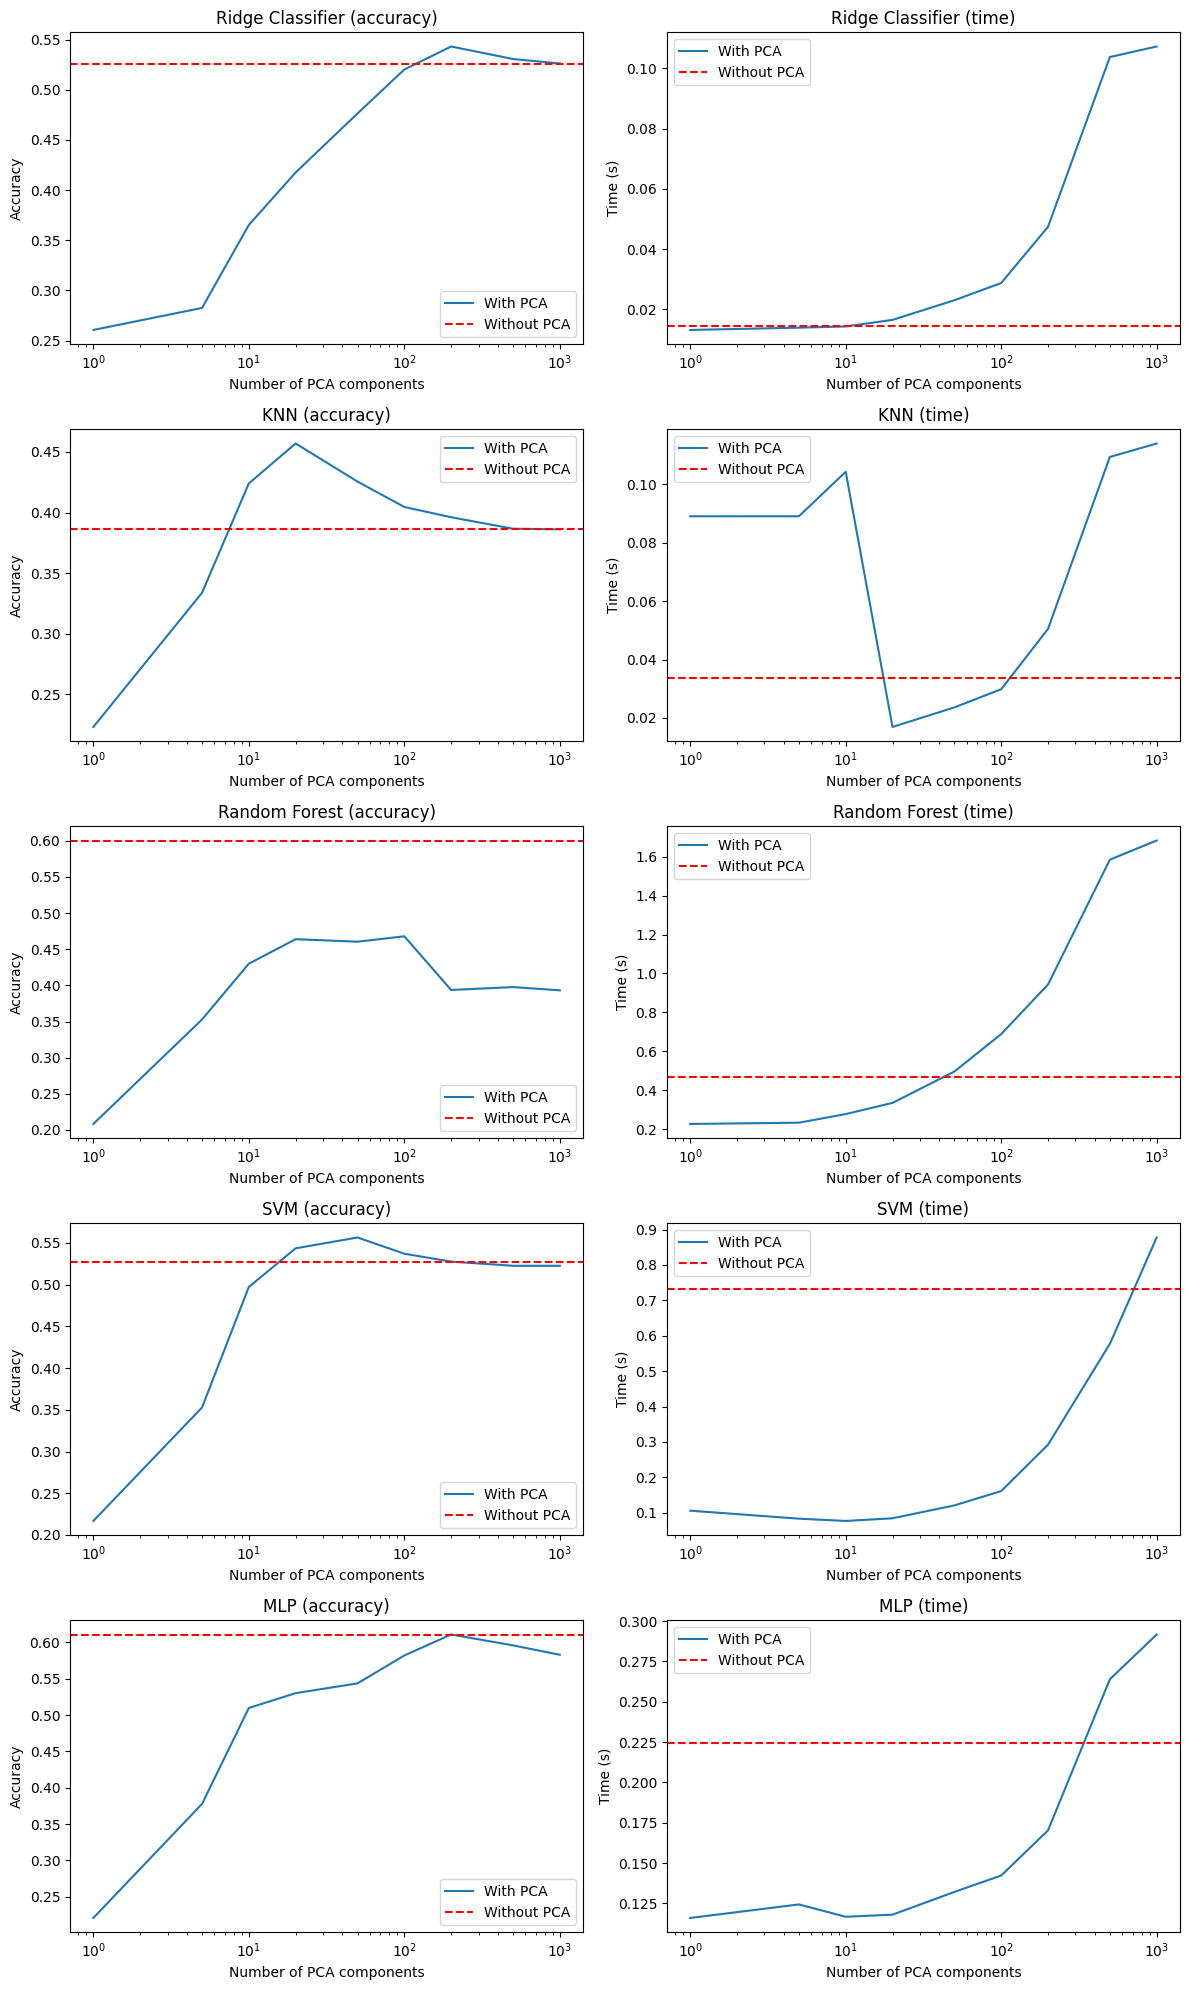

In [36]:
results = {name: [] for _, name in methods}
d_list = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

for d in d_list:
    t0 = time.time()
    
    pca = PCA(n_components = d).fit(XtrainS)
    XtrainSp = pca.transform(XtrainS)
    XtestSp = pca.transform(XtestS)
    XtrainTp = pca.transform(XtrainT)
    XtestTp = pca.transform(XtestT)

    time_PCA = time.time() - t0

    for method, name in methods:
        score, t = train_evaluate(method, name, XtrainSp, ytrainS, XtestTp, ytestT, verbose = False)
        results[name].append((d, score, t + time_PCA))

plot_results(methods, results, results_basic, label_baseline = "Without PCA", label_adapt = "With PCA")

**Answer**:

For Ridge Classifier, KNN, SVM and MLP, we do not see much of a difference with or without PCA. For some values of $d$, the obtained accuracy is smaller than without PCA, and for some values of $d$, the accuracy is higher.

For *linear* models (Ridge classification) this is understandable: PCA simply applies a first linear step, which could perfectly be handled by the model itself on the original data. This also holds for the MLP, for which simply modifying the first weight matrix could yield the same results.

As for the Random Forest, the results are much worse with PCA than without PCA. This is once again understandable: decision trees are *not* robust to affine transformations of the input data. Indeed, the splits made by a decision trees are based on the coordinates of the feature vectors. So when changing of basis (which is essentially what PCA does), nothing guarantees that the decisions previously made by the trees on the first coordinate system can be made with these new coordinates. In fact, here with images, the first coordinate system corresponds to individual pixels, which, we can assume, can be quite well handled by a decision tree (if there are pixels in this specific area, this could be the loop of an 8 or a 9, etc.). When mixing pixels to get new coordinates, things get much more complex than what decision trees can handle.

We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?

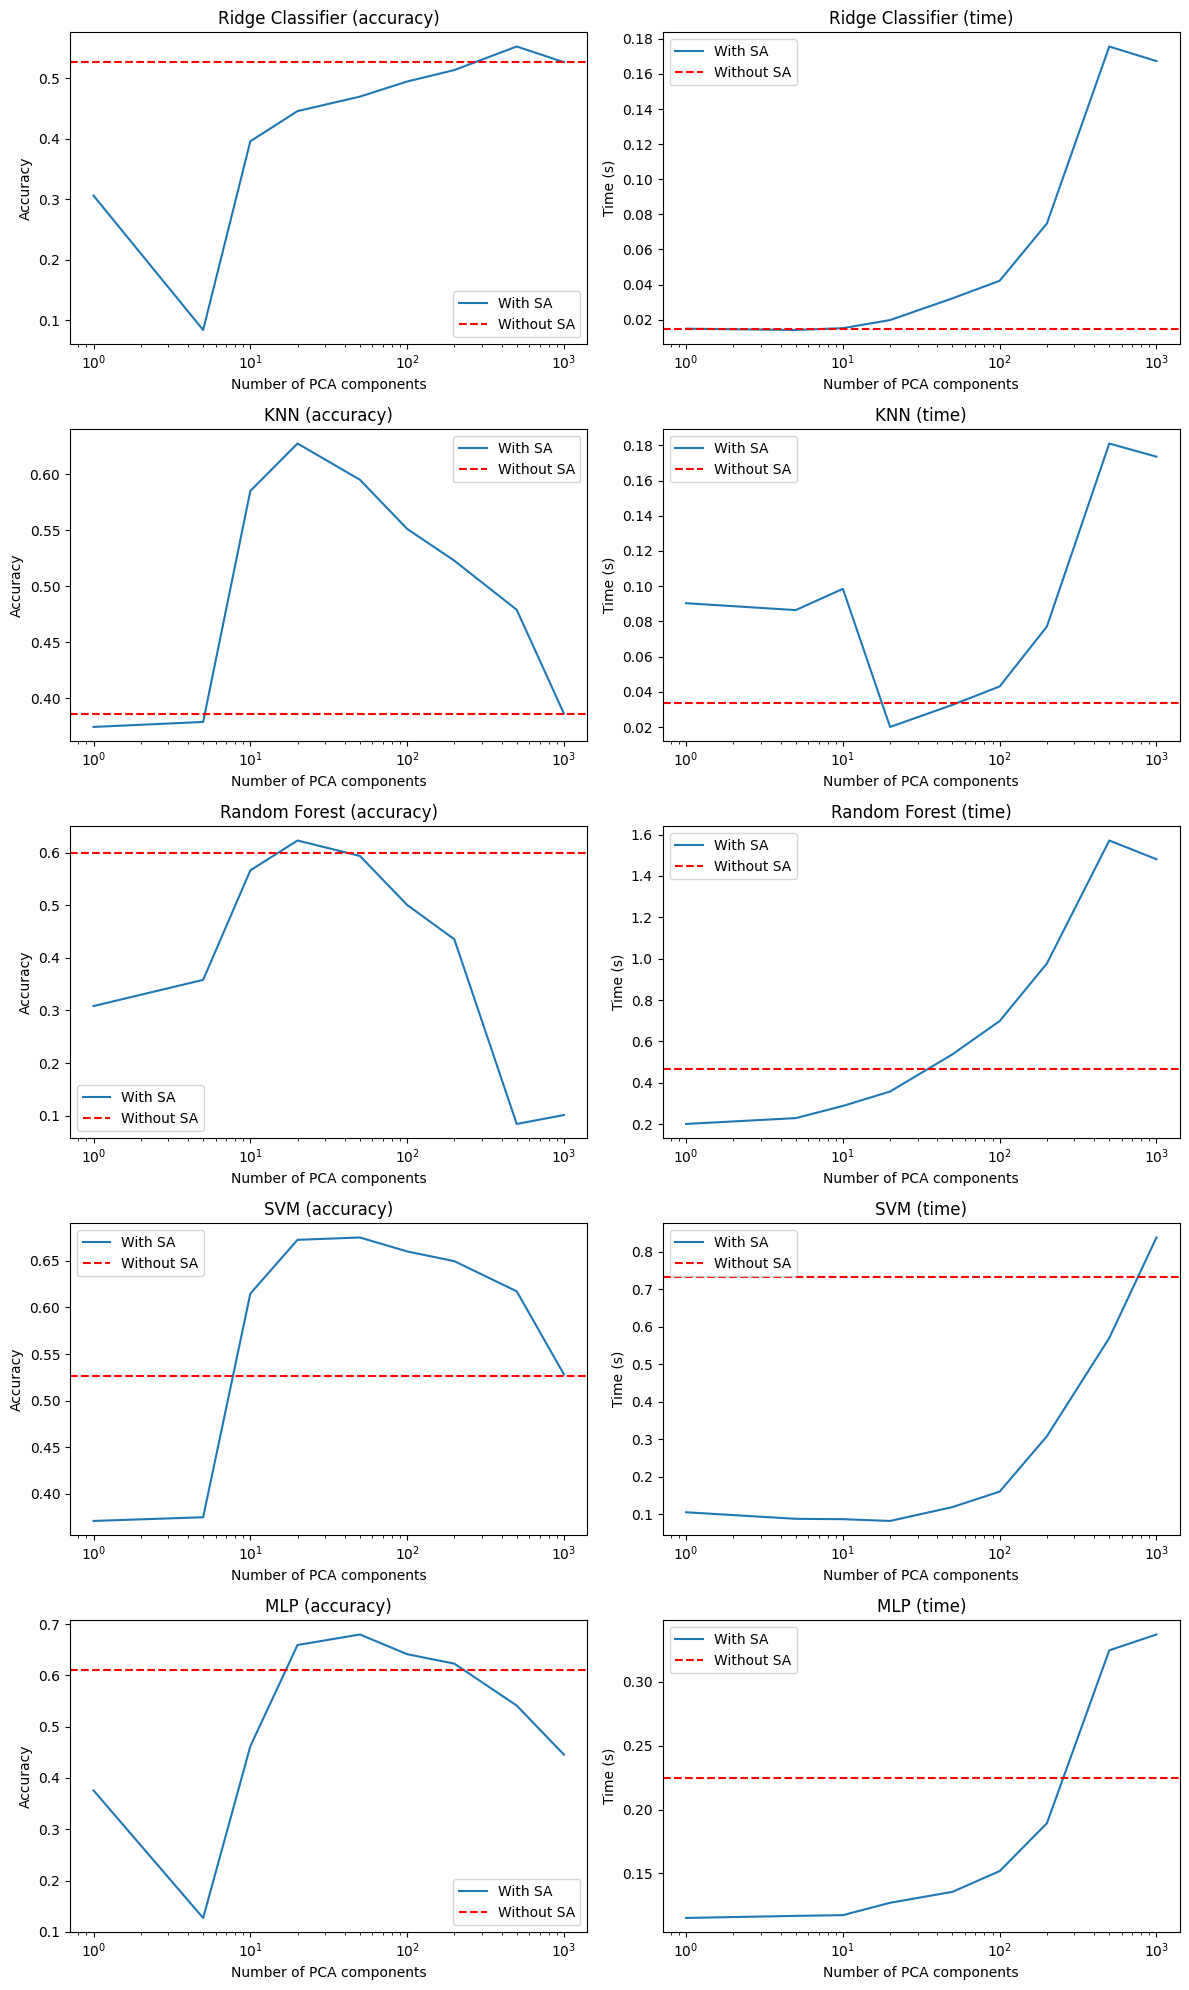

In [37]:
results = {name: [] for _, name in methods}
d_list = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

for d in d_list:
    t0 = time.time()
    
    XtrainSp, XtestSp, XtrainTp, XtestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    time_SA = time.time() - t0

    for method, name in methods:
        score, t = train_evaluate(method, name, XtrainSp, ytrainS, XtestTp, ytestT, verbose = False)
        results[name].append((d, score, t + time_SA))
    
plot_results(methods, results, results_basic, label_baseline = "Without SA", label_adapt = "With SA")

**Answer**: Things are now different than with a basic PCA, because the linear maps applied to source data and target data are not the same anymore.

However, for ridge classification, we have basically no improvement, just like before.

For the other models, we notice some improvement, especially for $d = 20$. We can hypothetize that SA with $d = 20$ indeed properly aligns the source data and the target data. This is especially visible for kNN, which was expected (comparing images pixel-wise is clearly not a good idea, but feature-wise seems reasonable).

For the random forest, except for $d = 20$, the results are really poor. The same reasoning as before applies (the "easy" coordinate system is no longer used).

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

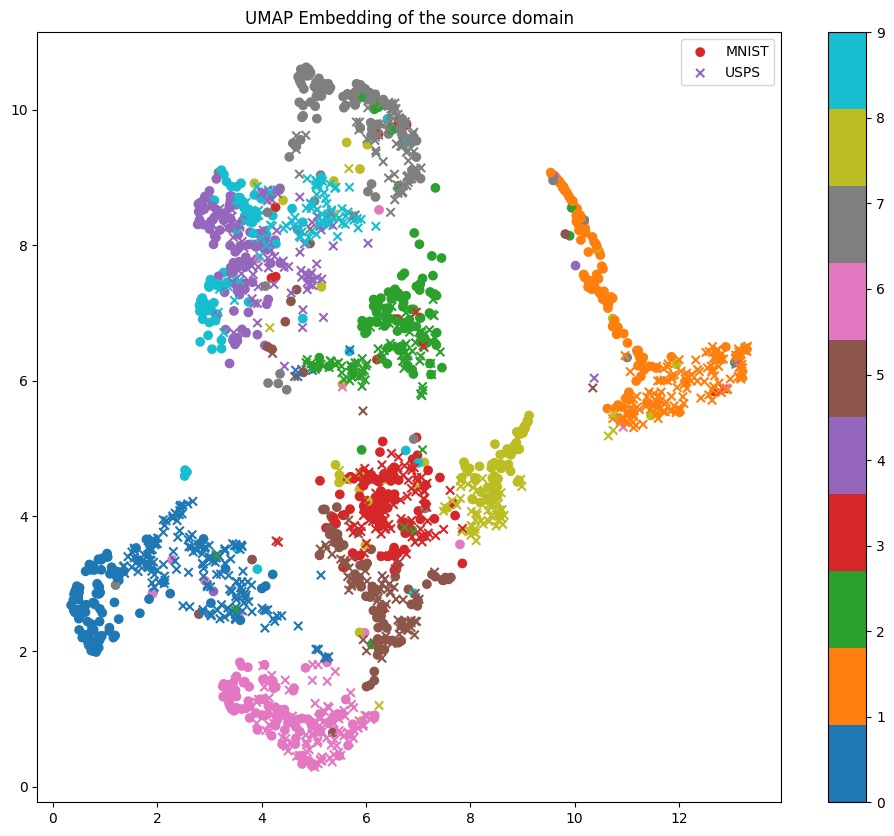

In [38]:
d = 200
XtrainSp, XtestSp, XtrainTp, XtestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

x_STp = np.concatenate((XtrainSp, XtrainTp), axis = 0)

xp = UMAP().fit_transform(x_STp)

xpMNIST = xp[:MNIST_Xtrain_res.shape[0], :]
xpUSPS = xp[MNIST_Xtrain_res.shape[0]: MNIST_Xtrain_res.shape[0] + USPS_Xtrain_res.shape[0], :]

plt.figure(3, (12, 10))
plt.scatter(xpMNIST[:, 0], xpMNIST[:, 1], c = MNIST_ytrain_res, marker = 'o', cmap = 'tab10', label = 'MNIST')
plt.scatter(xpUSPS[:, 0], xpUSPS[:, 1], c = USPS_ytrain_res, marker = 'x', cmap = 'tab10', label = 'USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the source domain')
plt.show()

**Answer**: for $d = 20$ (which led to good results with the different models), we observe the source and target data are not fully aligned, but we still got some improvements for classes 2, 3, 7, 8 (before, there was a clear separation between source and target for these classes).

Classes 4 and 9, which were mixed previously, still are.

And class 1 looks worse than before: source images and target images are mixed up now.

But overall, we did get some improvements.

**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

**Queston**: Comment the results

In [39]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = SVHN_Xtrain_res
ytrainT = SVHN_ytrain_res
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

Score without adaptation (Ridge Classifier): 0.090
Score without adaptation (KNN): 0.161
Score without adaptation (Random Forest): 0.076
Score without adaptation (SVM): 0.127
Score without adaptation (MLP): 0.111


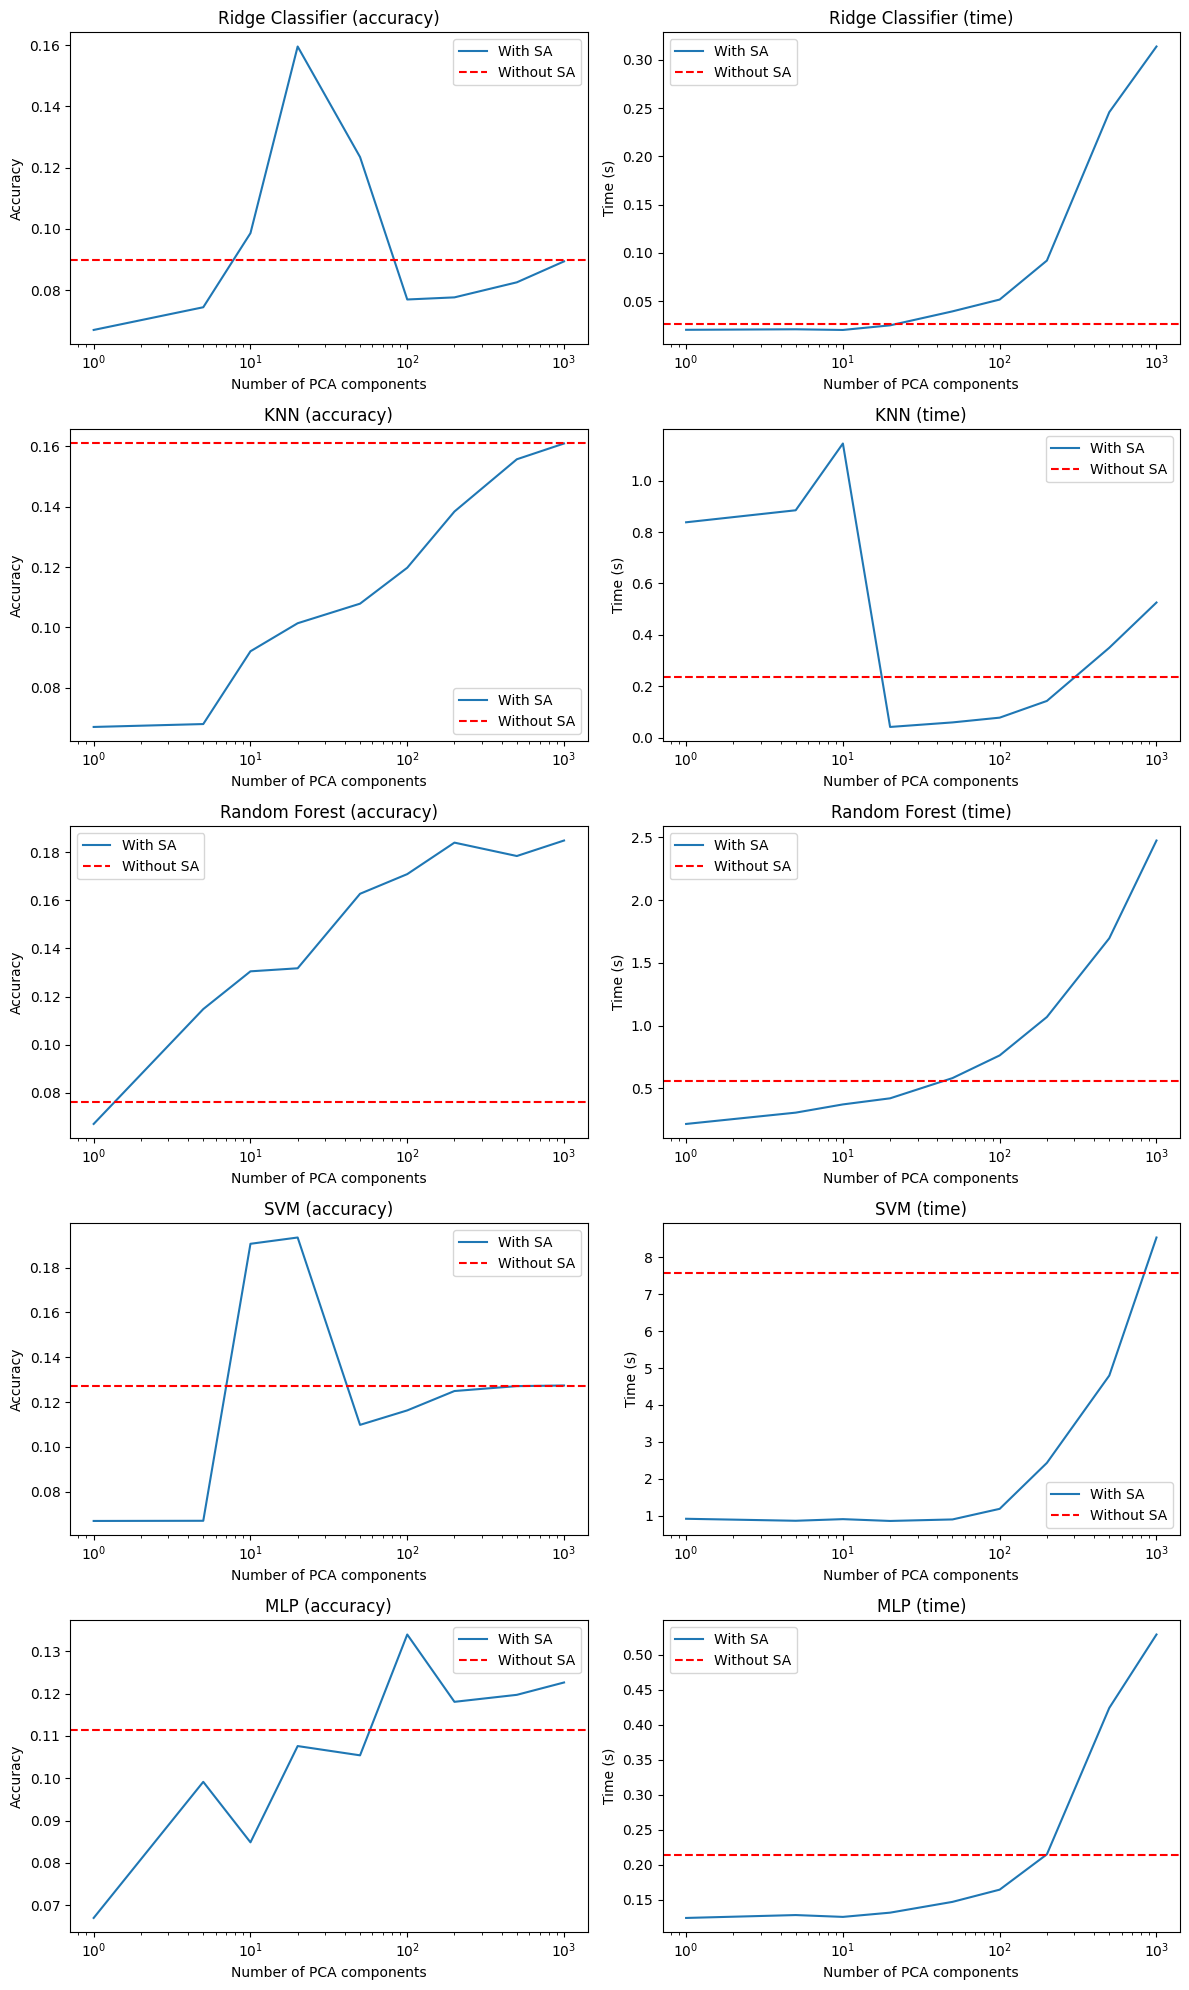

In [40]:
Ns = 1000 # number of samples in source domain
Nt = 1000 # number of samples in target domain

# Get scores without adaptation
results_basic = {}

for method, name in methods:
    score, t = train_evaluate(method, name, XtrainS, ytrainS, XtestT, ytestT)
    results_basic[name] = (score, t)

# Get scores with subspace alignment for each method and each number of PCA components (d)
results = {name: [] for _, name in methods}
d_list = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

for d in d_list:
    t0 = time.time()
    XtrainSp, XtestSp, XtrainTp, XtestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)
    time_SA = time.time() - t0

    for method, name in methods:
        score, t = train_evaluate(method, name, XtrainSp, ytrainS, XtestTp, ytestT, verbose = False)
        results[name].append((d, score, t + time_SA))

# Plot the scores with and without SA
plot_results(methods, results, results_basic, label_baseline = "Without SA", label_adapt = "With SA")

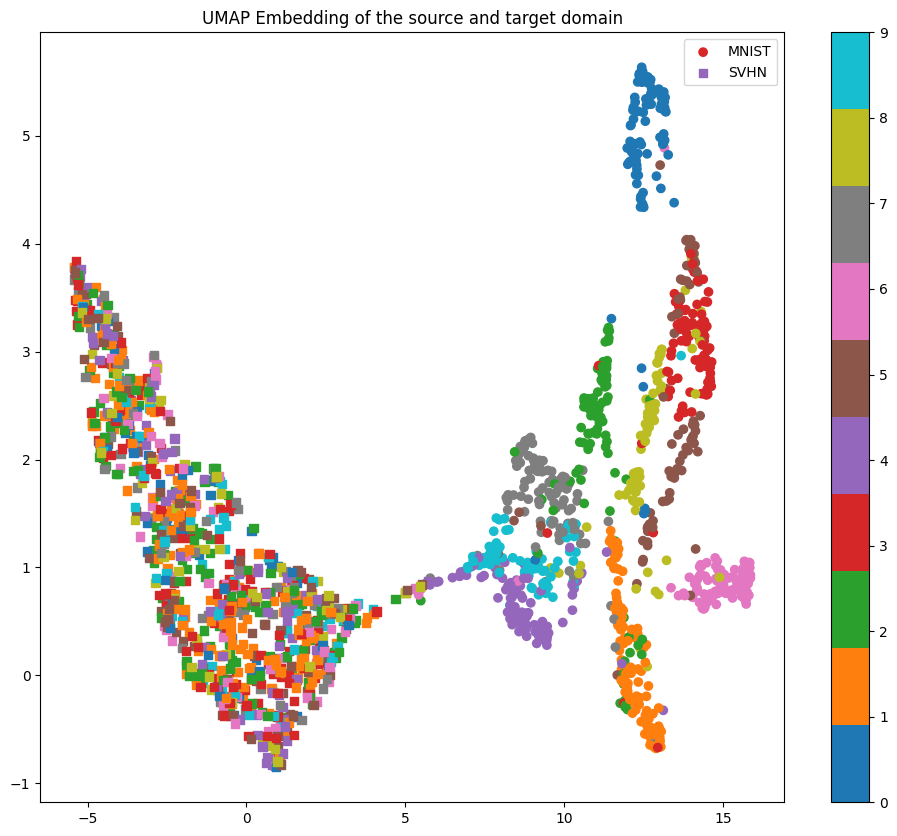

In [41]:
# Plot the UMAP embedding of the source and target domain
d = 1000
XtrainSp, XtestSp, XtrainTp, XtestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)
xtot = np.concatenate((XtrainSp, XtrainTp), axis = 0)

xp = UMAP().fit_transform(xtot)

xpS = xp[:XtrainSp.shape[0], :]
xpT = xp[XtrainSp.shape[0]:, :]
plt.figure(3, (12, 10))
plt.scatter(xpS[:, 0], xpS[:, 1], c = ytrainS, marker = 'o', cmap = 'tab10', label = 'MNIST')
plt.scatter(xpT[:, 0], xpT[:, 1], c = ytrainT, marker = 's', cmap = 'tab10', label = 'SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the source and target domain')
plt.show()

**Answer**: in the embedding, the source data and target data still do not look aligned. We could guess (but that's just a guess, since we only see the 2D embeddings) that this causes the KNN model to fail.

For most of the models, depending on $d$, there is (a small) improvement, or not.

What is surprising is what happens for the random forest: the results are improved compared to the basic method (without SA). This can be explained by the fact that in the basic method, the source data and target data are very different, so the method fails. When applying SA, even though we no longer work with pixels, the model manages to extract more information than with raw pixels, hence the improvement.

**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?

Score without adaptation (Ridge Classifier): 0.479
Score without adaptation (KNN): 0.316


Score without adaptation (Random Forest): 0.524
Score without adaptation (SVM): 0.447
Score without adaptation (MLP): 0.447


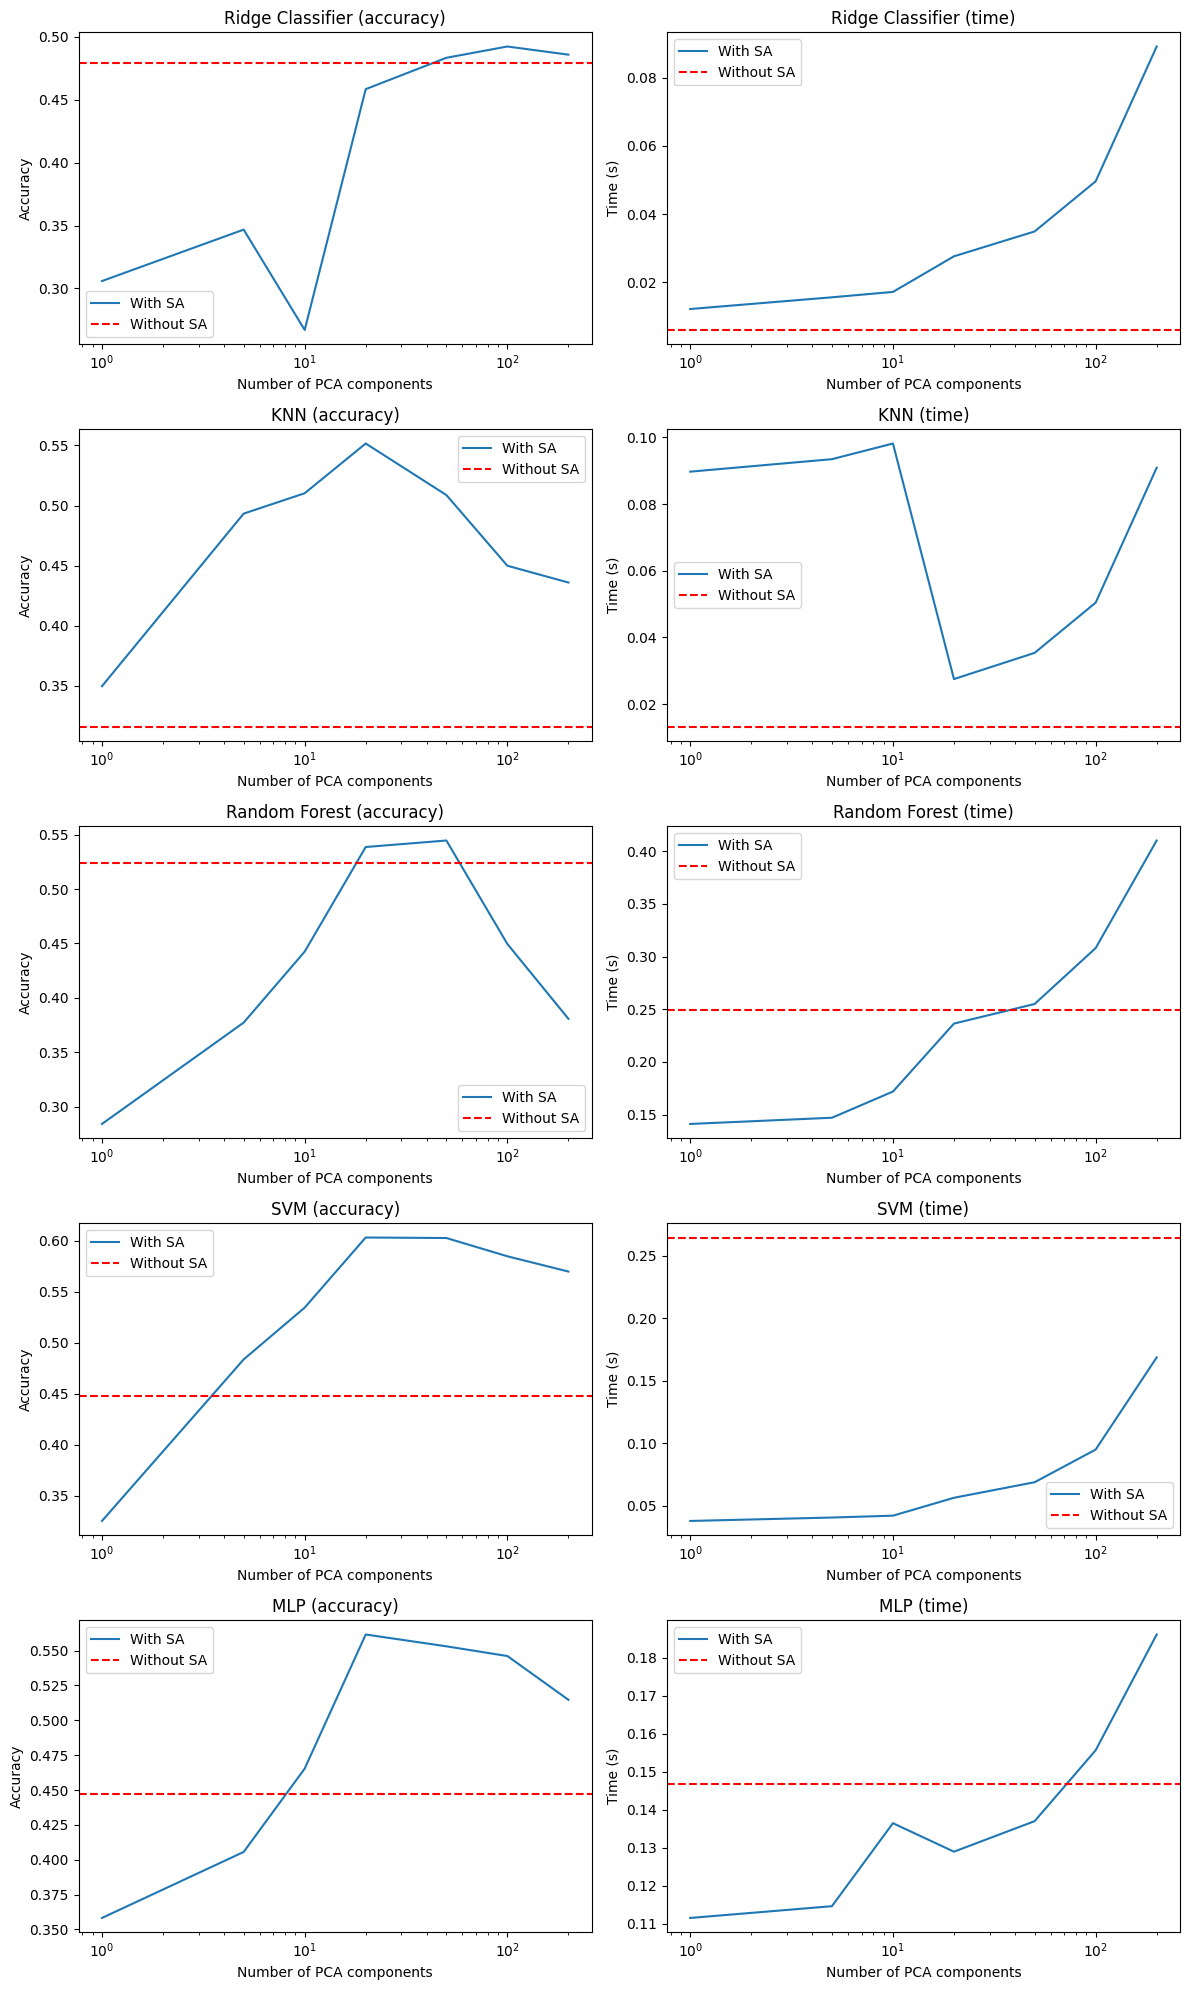

In [43]:
np.random.seed(0)
n_samples = 300

# Reduced MNIST
idx = np.random.choice(MNIST_Xtrain.shape[0], n_samples, replace = False)
MNIST_Xtrain_res = MNIST_Xtrain[idx]
MNIST_ytrain_res = MNIST_ytrain[idx]

# Reduced USPS
idx = np.random.choice(USPS_Xtrain.shape[0], 1000, replace = False)
USPS_Xtrain_res = USPS_Xtrain[idx]
USPS_ytrain_res = USPS_ytrain[idx]

XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

results_basic = {}

for method, name in methods:
    score, t = train_evaluate(method, name, XtrainS, ytrainS, XtestT, ytestT)
    results_basic[name] = (score, t)

results = {name: [] for _, name in methods}
d_list = [1, 5, 10, 20, 50, 100, 200]

for d in d_list:
    t0 = time.time()
    
    XtrainSp, XtestSp, XtrainTp, XtestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    time_SA = time.time() - t0

    for method, name in methods:
        score, t = train_evaluate(method, name, XtrainSp, ytrainS, XtestTp, ytestT, verbose = False)
        results[name].append((d, score, t + time_SA))
    
plot_results(methods, results, results_basic, label_baseline = "Without SA", label_adapt = "With SA")

**Answer**: when using less samples for the training source dataset, we get worse results on the target dataset. This was expected since, in the course, we saw an upper-bound of $e_T(\hat{f}_S) - e_T(\tilde{f}_T)$ by a term in $\sqrt{\frac{\log n}{n}}$, which goes to $0$ as $n$ approaches $+\infty$, but is larger for low values of $n$.